## Jackknife without binning

In [1]:
#Step 1: make configurations 

import numpy as np
from tqdm import tqdm


N = 256
num_configs = 100000
thermalization = 1000000
separation = 1000
K = 0.7

probability_accept = np.exp(-4*K)

def update(s):

    site = np.random.randint(N)

    if s[site] == s[site - 1] and s[site] == s[(site + 1) % N]:
        if np.random.uniform() < probability_accept:
            s_new = s.copy()
            s_new[site] = -s[site]
            return s_new
        else:
            return s
    else:
        s_new = s.copy()
        s_new[site] = -s[site]
        return s_new

s = [1] * N

for _ in tqdm(range(thermalization), desc="thermalization"):
    s = update(s)

walk = []

for config in tqdm(range(num_configs), desc="config"):
    for _ in range(separation):
        s = update(s)
    walk.append(s)

with open("configurations.dat", "w") as file:
    for config in walk:
        config_parsed = ""
        for spin in config:
            config_parsed += str(spin) + " "
        config_parsed += "\n"
        file.write(config_parsed)

config: 100%|██████████████████████████| 100000/100000 [02:27<00:00, 678.24it/s]


In [4]:
import numpy as np
from tqdm import tqdm

# Load raw configurations
walk = []
with open("configurations.dat", "r") as file:
    for line in file.readlines():
        walk.append([int(spin) for spin in line.split(" ")[:-1]])

N = len(walk[0])

jk_samples = []

for delta in tqdm(range(N),desc='delta'):
    two_pt = 0
    for config in walk:
        average = 0
        for site in range(N):
            average += config[site] * config[(site + delta) % N]
        average /= N
        two_pt += average
    two_pt /= len(walk)

    two_pt_jk = []
    for tau in range(len(walk)):
        two_pt_tau = 0
        for site in range(N):
            two_pt_tau += walk[tau][site] * walk[tau][(site + delta) % N]
        two_pt_tau /= N
        two_pt_jk.append((len(walk)*two_pt - two_pt_tau)/(len(walk) - 1))
    
    if not jk_samples:
        jk_samples = [[val] for val in two_pt_jk]
    else:
        for i in range(len(walk)):
            jk_samples[i].append(two_pt_jk[i])

# Save result

with open("twopt_jk_no_bin.dat", "w") as file:
    for row in jk_samples:
        file.write(" ".join(f"{val}" for val in row) + "\n")

delta: 100%|██████████████████████████████████| 256/256 [17:58<00:00,  4.21s/it]


/var/folders/wk/x7r25gnx1nd_fmk13dz2gn440000gn/T/ipykernel_2674/261479465.py:19: RuntimeWarning: invalid value encountered in log
  effective_mass_jk[i] = np.log(correlator_jk[i, :-1] / correlator_jk[i, 1:])
/var/folders/wk/x7r25gnx1nd_fmk13dz2gn440000gn/T/ipykernel_2674/261479465.py:19: RuntimeWarning: divide by zero encountered in divide
  effective_mass_jk[i] = np.log(correlator_jk[i, :-1] / correlator_jk[i, 1:])
/var/folders/wk/x7r25gnx1nd_fmk13dz2gn440000gn/T/ipykernel_2674/261479465.py:19: RuntimeWarning: divide by zero encountered in log
  effective_mass_jk[i] = np.log(correlator_jk[i, :-1] / correlator_jk[i, 1:])


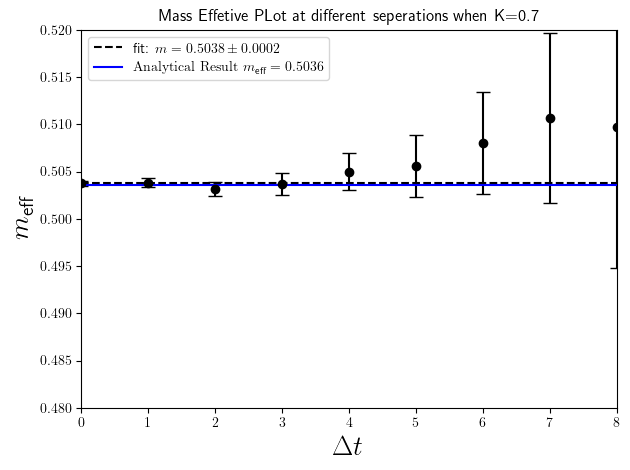

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{physics}"

correlator_jk = []
with open("twopt_jk_no_bin.dat", "r") as file:
    for line in file:
        correlator_jk.append([float(num) for num in line.strip().split()])

correlator_jk = np.array(correlator_jk)
N = len(correlator_jk)
T = correlator_jk.shape[1]
deltas = np.arange(T)

effective_mass_jk = np.zeros((N, T - 1))
for i in range(N):
    effective_mass_jk[i] = np.log(correlator_jk[i, :-1] / correlator_jk[i, 1:])

effective_mass = np.mean(effective_mass_jk, axis=0)
err = np.std(effective_mass_jk, axis=0) * np.sqrt(N - 1)

def const_model(t, m):
    return m

fit_start, fit_end = 0, 10
t_fit = deltas[fit_start:fit_end - 1]  
m_eff_fit = effective_mass[fit_start:fit_end - 1]
err_fit = err[fit_start:fit_end - 1]

popt, pcov = curve_fit(const_model, t_fit, m_eff_fit, sigma=err_fit, absolute_sigma=True)
m_plateau = popt[0]
m_plateau_err = np.sqrt(np.diag(pcov))[0]

# analytical result 
analytical_result = -np.log(np.tanh(0.7))

fig, ax = plt.subplots()
ax.errorbar(deltas[:-1], effective_mass, yerr=err, color="k", fmt="o", capsize=5)
ax.axhline(m_plateau, color="black", linestyle="--", label=fr"fit: $m = {m_plateau:.4f} \pm {m_plateau_err:.4f}$")
ax.axhline(y=analytical_result, color='blue', linestyle='-', linewidth=1.5,
           label=fr"$\mathrm{{Analytical\ Result}}$ $m_\text{{eff}} = {analytical_result:.4f}$")
ax.set_xlabel(r"$\Delta t$", fontsize=20)
ax.set_ylabel(r"$m_\text{eff}$", fontsize=20)
ax.legend()
plt.title('Mass Effetive PLot at different seperations when K=0.7')
plt.xlim(0,8)
plt.ylim(0.48,0.52)
plt.tight_layout()
plt.savefig('Mass_Effetive_Plot_at_diff_seperations_K=0.7.pdf')
plt.show()

256


plots: 4it [02:51, 42.80s/it]


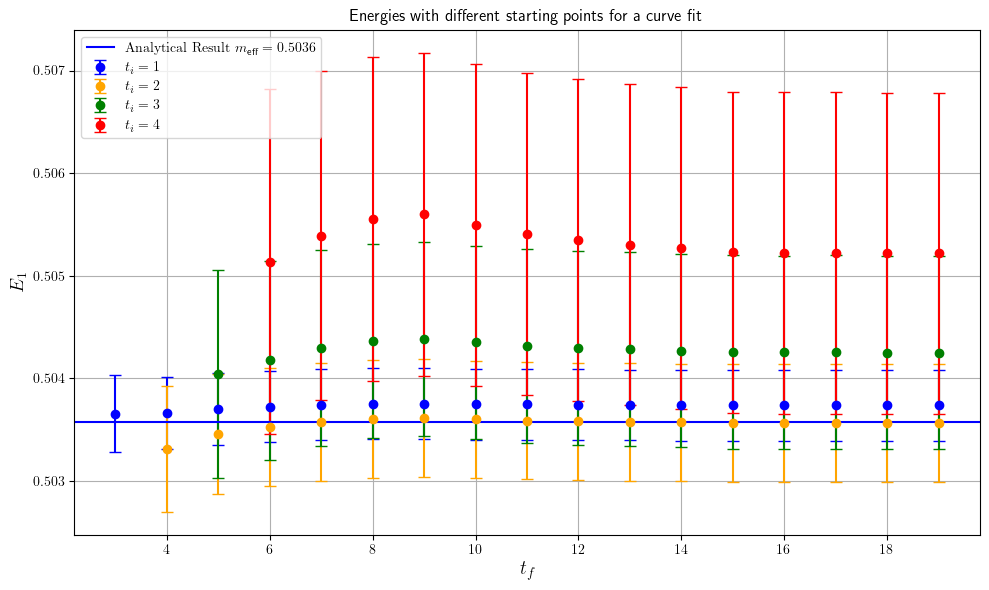

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

correlator_jk = []
with open("twopt_jk_no_bin.dat", "r") as file:
    for line in file:
        correlator_jk.append([float(num) for num in line.strip().split()])

correlator_jk = np.array(correlator_jk)
N_jk = correlator_jk.shape[0]
T = correlator_jk.shape[1]
print(T)

t_i_values = [1, 2, 3, 4]
colors = ['blue', 'orange', 'green', 'red']

# analytical result 
analytical_result = -np.log(np.tanh(0.7))

plt.figure(figsize=(10, 6))

def constant_model(t, m):
    return m

for idx, t_i in tqdm(enumerate(t_i_values),desc='plots'):
    t_f_values = np.arange(t_i + 1, T)
    energies = []
    energies_err = []

    for t_f in t_f_values:
        t_range = np.arange(t_i, t_f + 1)

        eff_mass_jk = []
        for i in range(N_jk):
            y = correlator_jk[i, t_i:t_f + 1]
            if len(y) < 3 or np.any(y <= 1e-15):
                continue 

            eff_mass = np.log(y[:-1] / y[1:])
            eff_mass_jk.append(eff_mass)

        if len(eff_mass_jk) == 0:
            energies.append(np.nan)
            energies_err.append(np.nan)
            continue

        eff_mass_jk = np.array(eff_mass_jk)

        eff_mass_avg = np.mean(eff_mass_jk, axis=0)
        eff_mass_err = np.std(eff_mass_jk, axis=0) * np.sqrt(len(eff_mass_jk) - 1)

        t_eff = t_range[:-1]

        try:
            popt, pcov = curve_fit(constant_model, t_eff, eff_mass_avg, sigma=eff_mass_err, absolute_sigma=True)
            m_fit = popt[0]
            m_err = np.sqrt(np.diag(pcov))[0]
        except Exception as e:
            m_fit = np.nan
            m_err = np.nan

        energies.append(m_fit)
        energies_err.append(m_err)

    energies = np.array(energies)
    energies_err = np.array(energies_err)

    if np.all(np.isnan(energies)):
        continue

    plt.errorbar(t_f_values, energies, yerr=energies_err, fmt='o', color=colors[idx],
                 capsize=4, label=f'$t_i = {t_i}$')
plt.axhline(y=analytical_result, color='blue', linestyle='-', linewidth=1.5,
           label=fr"$\mathrm{{Analytical\ Result}}$ $m_\text{{eff}} = {analytical_result:.4f}$")
plt.xlabel(r'$t_f$', fontsize=14)
plt.ylabel('$E_1$', fontsize=14)
plt.title('Energies with different starting points for a curve fit ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Energies_with_diff_starting_points_curve_fit.pdf')
plt.show()

## Jackknife with binning

In [7]:
import numpy as np
from tqdm import tqdm

bin_size = 100

# Load raw configurations
walk = []
with open("configurations.dat", "r") as file:
    for line in tqdm(file,desc='line'):
        walk.append([int(spin) for spin in line.strip().split()])

walk = np.array(walk)
num_configs, N = walk.shape
num_bins = num_configs // bin_size

# Reshape into bins
walk_binned = walk[:num_bins * bin_size].reshape(num_bins, bin_size, N)

# Average each bin along axis=1 (over the 100 configs)
walk_bin_avg = np.mean(walk_binned, axis=1)

# Now walk_bin_avg has shape (num_bins, N) and we treat each row as a binned config
jk_samples = []

for delta in tqdm(range(N),desc='deltas'):
    # Compute full-sample two-point function
    two_pt = 0
    for config in walk_bin_avg:
        average = np.mean(config * np.roll(config, delta))
        two_pt += average
    two_pt /= num_bins

    # Jackknife
    two_pt_jk = []
    for i in range(num_bins):
        excluded = np.delete(walk_bin_avg, i, axis=0)
        avg = 0
        for config in excluded:
            avg += np.mean(config * np.roll(config, delta))
        avg /= (num_bins - 1)
        two_pt_jk.append(avg)

    # Append jackknife values for this delta
    if not jk_samples:
        jk_samples = [[val] for val in two_pt_jk]
    else:
        for i in range(num_bins):
            jk_samples[i].append(two_pt_jk[i])

# Save to file
with open("twopt_jk_binned.dat", "w") as file:
    for row in jk_samples:
        file.write(" ".join(f"{val}" for val in row) + "\n")


line: 100000it [00:02, 47539.98it/s]
deltas: 100%|█████████████████████████████████| 256/256 [20:59<00:00,  4.92s/it]


<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/wk/x7r25gnx1nd_fmk13dz2gn440000gn/T/ipykernel_2674/3541504532.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.errorbar(deltas, effective_mass, yerr=err, fmt='o', capsize=4, color='black', label='Binned $m_{\mathrm{eff}}$')
/var/folders/wk/x7r25gnx1nd_fmk13dz2gn440000gn/T/ipykernel_2674/3541504532.py:14: RuntimeWarning: invalid value encountered in log
  effective_mass_jk = np.log(correlator_jk[:, :-1] / correlator_jk[:, 1:])


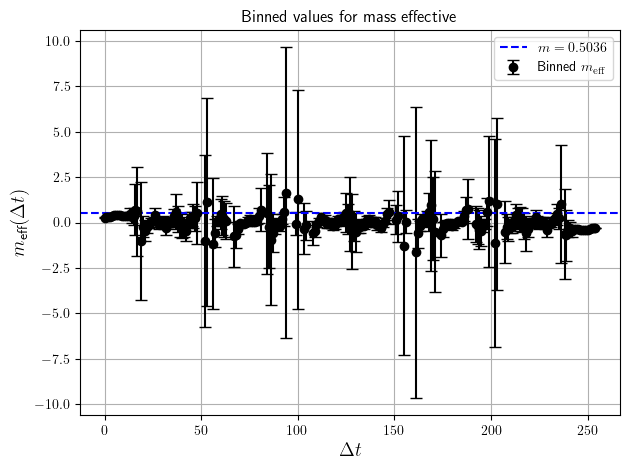

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Load binned jackknife data
correlator_jk = []
with open("twopt_jk_binned.dat", "r") as file:
    for line in file:
        correlator_jk.append([float(num) for num in line.strip().split()])

correlator_jk = np.array(correlator_jk)
N_jk, T = correlator_jk.shape

# Compute effective mass per jackknife sample
effective_mass_jk = np.log(correlator_jk[:, :-1] / correlator_jk[:, 1:])

# Jackknife mean and error
effective_mass = np.mean(effective_mass_jk, axis=0)
err = np.std(effective_mass_jk, axis=0) * np.sqrt(N_jk - 1)

# Plot
deltas = np.arange(T - 1)
plt.errorbar(deltas, effective_mass, yerr=err, fmt='o', capsize=4, color='black', label='Binned $m_{\mathrm{eff}}$')

# Optional: analytical result
analytical = -np.log(np.tanh(0.7))
plt.axhline(y=analytical, color='blue', linestyle='--', label=fr'$m = {analytical:.4f}$')

plt.xlabel(r'$\Delta t$', fontsize=14)
plt.ylabel(r'$m_\text{eff}(\Delta t)$', fontsize=14)
plt.legend()
plt.grid(True)
plt.title("Binned values for mass effective")
# plt.xlim(0,50)
# plt.ylim(0.2,0.6)
plt.tight_layout()
plt.savefig("Binned_values_mass_effective.pdf")
plt.show()


In [8]:
from tqdm import tqdm
import numpy as np

# === PARAMETERS ===
n = 2
K = 0.5 * np.log(1 + np.sqrt(2))
B = 0.5 * np.log(np.tanh(K))
J = 2 * (K - B) + B

# === LOAD CONFIGURATIONS ===
walk = []
with open("configurations.dat", "r") as file:
    for line in file:
        walk.append([int(spin) for spin in line.strip().split()])
walk = np.array(walk[:10000])
num_configs, L = walk.shape
p = 2 * np.pi * n / L

# === O(t, p) ===
O_p_t = np.empty(num_configs, dtype=np.complex128)
for t in tqdm(range(num_configs), desc="Computing O(t, p)"):
    O_p_t[t] = np.sum(walk[t] * np.exp(1j * p * np.arange(L)))

# === JACKKNIFE CORRELATOR ===
correlator_jk = []
for i in tqdm(range(num_configs), desc="Jackknife loop"):
    reduced = np.delete(O_p_t, i)
    N = len(reduced)
    C_reduced = np.array([
        np.real(reduced[t] * np.conj(reduced[0]))
        for t in range(1, N)
    ])
    correlator_jk.append(C_reduced)

correlator_jk = np.array(correlator_jk)
np.save("momentum_correlator_jk.npy", correlator_jk)

Jackknife loop: 100%|████████████████████| 10000/10000 [01:09<00:00, 143.22it/s]


Fitting t_i:   0%|                                        | 0/3 [00:00<?, ?it/s]/var/folders/wk/x7r25gnx1nd_fmk13dz2gn440000gn/T/ipykernel_1557/2409721549.py:52: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(constant_model, t_eff, eff_mass_avg, sigma=eff_mass_err, absolute_sigma=True)
Fitting t_i: 100%|███████████████████████████████| 3/3 [13:33<00:00, 271.21s/it]


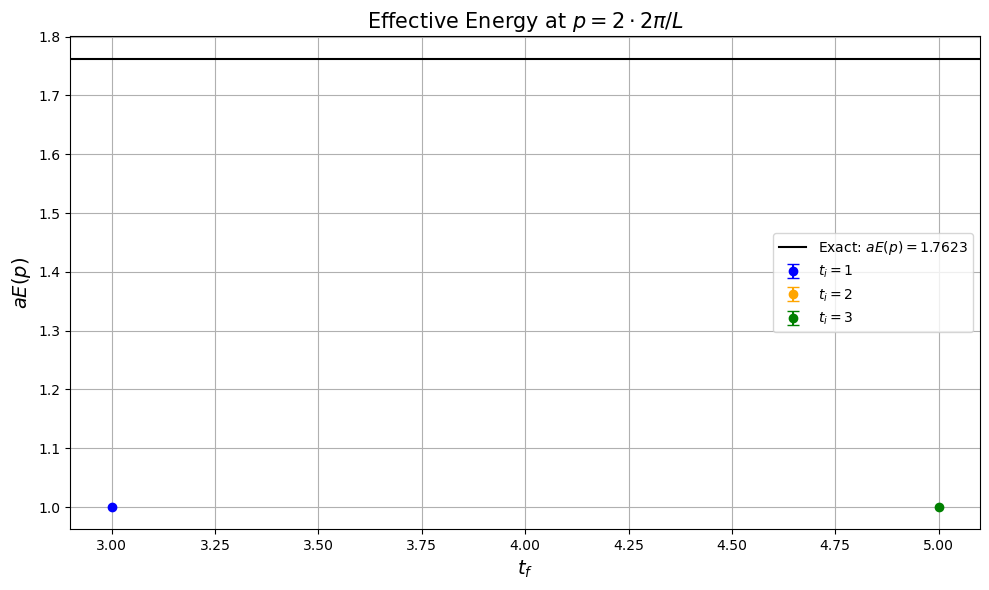

In [9]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === LOAD CORRELATOR ===
correlator_jk = np.load("momentum_correlator_jk.npy")
N_jk, T = correlator_jk.shape

# === PARAMETERS ===
n = 2
K = 0.5 * np.log(1 + np.sqrt(2))
B = 0.5 * np.log(np.tanh(K))
J = 2 * (K - B) + B
p = 2 * np.pi * n / 256  # adjust for your L

t_i_values = [1, 2, 3]
colors = ['blue', 'orange', 'green']
analytical_result = np.sqrt(J**2 + B**2 - 2 * J * B * np.cos(p))

def constant_model(t, m):
    return m

plt.figure(figsize=(10, 6))

for idx, t_i in tqdm(enumerate(t_i_values), desc='Fitting t_i', total=len(t_i_values)):
    t_f_values = np.arange(t_i + 1, T)
    energies, energies_err = [], []

    for t_f in t_f_values:
        t_range = np.arange(t_i, t_f + 1)
        eff_mass_jk = []

        for i in range(N_jk):
            y = correlator_jk[i, t_i:t_f + 1]
            if len(y) < 3 or np.any(y <= 1e-15):
                continue
            eff_mass = np.log(y[:-1] / y[1:])
            eff_mass_jk.append(eff_mass)

        if not eff_mass_jk:
            energies.append(np.nan)
            energies_err.append(np.nan)
            continue

        eff_mass_jk = np.array(eff_mass_jk)
        eff_mass_avg = np.mean(eff_mass_jk, axis=0)
        eff_mass_err = np.std(eff_mass_jk, axis=0) * np.sqrt(len(eff_mass_jk) - 1)
        t_eff = t_range[:-1]

        try:
            popt, pcov = curve_fit(constant_model, t_eff, eff_mass_avg, sigma=eff_mass_err, absolute_sigma=True)
            m_fit = popt[0]
            m_err = np.sqrt(np.diag(pcov))[0]
        except:
            m_fit, m_err = np.nan, np.nan

        energies.append(m_fit)
        energies_err.append(m_err)

    plt.errorbar(t_f_values, energies, yerr=energies_err, fmt='o',
                 color=colors[idx % len(colors)], capsize=4, label=f'$t_i = {t_i}$')

plt.axhline(y=analytical_result, color='black', linestyle='-', linewidth=1.5,
            label=fr"Exact: $aE(p) = {analytical_result:.4f}$")
plt.xlabel(r'$t_f$', fontsize=14)
plt.ylabel(r'$aE(p)$', fontsize=14)
plt.title(rf'Effective Energy at $p = {n} \cdot 2\pi / L$', fontsize=15)
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('Effective_Energy_p_mode.pdf')
plt.show()